In [55]:
%cd /Users/helloworld/Home/Desktop/amugeona/LNS_floating/

/Users/helloworld/Home/Desktop/amugeona/LNS_floating


# Fluid surface dynamics

Based on: "Non-wetting impact of a sphere onto a bath and its application to bouncing droplets" by Galeano-Rios, Milewski, and Vanden-Broeck (2017)

Included forces:
- Gravity effects (Froude number)
- Surface tension (Weber number)
- Viscous dissipation (Reynolds number)

**Coordinate System** (matches paper):
- z = 0 at free surface
- z = -D at solid bottom
- (Internally computed with z_vec from 0 to D, transformed for visualization)

Notations:
- η: surface elevation
- φ: velocity potential
- w¹: horizontal vortical component (x-direction)
- w³: vertical vortical component (z-direction)
- w² = 0 in 2D (out-of-plane, zero by symmetry)


Key equations (2.15) from the paper:
- (2.15a): Laplace equation for velocity potential  
  
  $\Delta \phi = 0$

- (2.15b): vortical component evolution  
  
  $w_t^i = \frac{1}{Re} \Delta w^i$

- (2.15c): surface elevation evolution  
  
  $\eta_t = \phi_z + w^3$

- (2.15d): potential evolution at surface  
  
  $\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_{H} \phi - \frac{2}{Re} w^3_z - p_s$

- (2.15e): **vertical vortical component evolution at surface** (use this for w³ at surface!)
  
  $w_t^3 = \frac{2}{Re} \Delta_H\left(\phi_z + w^3\right)$

- ~~(2.17): $w^3 = \frac{2}{Re} \Delta_{H} \eta,\quad z = 0$~~ **NOT USED** - this is a derived relation valid only for specific initial conditions
  

Boundary conditions:
- **Top (z = 0, free surface)**: 
  - φ: Dirichlet from dynamic BC (2.15d)
  - w³: From equation (2.15e)
  - w¹: Stress-free from equation (2.11a): $w^1_z = -(\phi_{xz} + w^3_x)$
- **Bottom (z = -D, solid)**: Non-slip BC ($\mathbf{u} = 0$)
  - $w^3 = -\partial\phi/\partial z$ (vertical velocity = 0)
  - $w^1 = -\partial\phi/\partial x$ (horizontal velocity = 0)
- **Left & Right**: Periodic BC

In [56]:
import numpy as np
from scipy.sparse import lil_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
import math

In [57]:
import session_info
session_info.show()

#### Setting up constants

In [ ]:
# physical params
L_in_cm = 50.0 # length in x-dir (cm)
D_in_cm = 5.0 # depth in z-dir (cm)
g_accel = 980.0 # gravitational acceleration (cm/s^2)
sigma = 74.9 # surface tension (dyne/cm)
rho = 1.0 # density (g/cm^3)
nu = 0.002 # kinematic viscosity (cm^2/s)

# non-dimensionalization
Unit_length = 2.5
Unit_time = 0.05 # adjust....
Unit_velocity = Unit_length / Unit_time

# ===== FAST TEST PARAMETERS =====
# Reduced grid for quick testing (change back for production)
nx = 300  # was 400
nz = 30   # was 100
nt = 1000 # was 5000
total_time = 3.0  # was 3.0 seconds - shorter to catch early dynamics

# dimensionless params
L = L_in_cm / Unit_length
D = D_in_cm / Unit_length
T_total = total_time / Unit_time

# dimensionless numbers (eqn 2.14 in Galeano-Rios et al. 2017)
# Fr = V^2/(gL), We = ρV^2L/σ, Re = LV/ν
Fr = (Unit_velocity**2) / (g_accel * Unit_length)
We = (rho * (Unit_velocity**2) * Unit_length) / sigma
Re = (Unit_velocity * Unit_length) / nu

print(f"Dimless params: Froude number, Weber number, Reynolds number")
print(f"Fr: {Fr:.4f}, We: {We:.4f}, Re: {Re:.4f}")

# derived numerical constants
dx = L / nx
dz = D / nz
dt = T_total / nt

print(f"  Froude number Fr = V²/(gL) = {Fr:.4f}")
print(f"  Weber number  We = ρV²L/σ  = {We:.4f}")
print(f"  Reynolds number Re = VL/ν  = {Re:.2f}")
print(f"\nGrid: {nx} x {nz} points, dt = {dt:.6f}")
print(f"Total time: {total_time}s, {nt} steps")

Dimless params: Froude number, Weber number, Reynolds number
Fr: 1.0204, We: 83.4446, Re: 62500.0000
  Froude number Fr = V²/(gL) = 1.0204
  Weber number  We = ρV²L/σ  = 83.4446
  Reynolds number Re = VL/ν  = 62500.00

Grid: 300 x 30 points, dt = 0.060000
Total time: 3.0s, 1000 steps


#### Initial and boundary settings

In [59]:
  
def gaussian(x):
    """
    Initial surface elevation, just changed from sin/cos to gaussian bump
    """
    x0 = L/2 # center of the domain
    sigma_x = L/10 # width
    amplitude = 0.1 # small but visible
    return amplitude * np.exp(-(x-x0)**2 / (2*sigma_x**2))


def initial_eta(x):
    return gaussian(x) - np.mean(gaussian(x))


In [60]:
# Index conversion func

def to_1d_index(i, j):
    """
    Convert 2D grid indices to 1D array index
    """
    return i * nx + j

def to_2d_index(idx):
    """
    Convert 1D array index to 2D grid indices (i, j)
    """
    i = idx // nx
    j = idx % nx
    return i, j
    

#### Arry initialization

In [61]:
# main things
eta = np.zeros(nx) # surf elevation η(x, t)
phi = np.zeros((nz, nx)) # velocity potential ϕ(x, z, t)
w3 = np.zeros((nz, nx)) # vertical vortical component w^3(x, t), it's now 2d field (was 1d in 01_Surface_Dynamics)
w1 = np.zeros((nz, nx)) # horizontal vortical component

x_vec = np.linspace(0, L, nx, endpoint=False)
z_vec = np.linspace(0, D, nz)

# FIXED: Compute Gaussian for ALL x values first, THEN subtract mean
eta = gaussian(x_vec)  # Vectorized call
eta = eta - np.mean(eta)  # Now subtract mean of the whole array

print(f"Initial η: max = {np.max(eta):.6f}, min = {np.min(eta):.6f}, mean = {np.mean(eta):.2e}")

Initial η: max = 0.074934, min = -0.025066, mean = -2.22e-18


#### Operators

In [62]:
def build_Delta_H(n, dx):
    """Horizontal Laplacian for periodic BC"""
    D = lil_matrix((n, n))
    for j in range(n):
        D[j, j] = -2.0 / dx**2
        D[j, (j+1) % n] = 1.0 / dx**2
        D[j, (j-1) % n] = 1.0 / dx**2
    return D.tocsr()

def build_Laplace_matrix_nonslip(nx_l, nz_l, dx_l, dz_l):
    """
    Build matrix for Δϕ = 0 with BCs
    
    MODIFIED: Bottom BC is now non-slip (∂φ/∂z = -w^3) instead of Neumann
    - Top: Dirichlet (φ = φ_surface, handled in RHS)
    - Bottom: ∂φ/∂z = -w^3 (non-slip, handled via ghost point in RHS)
    - Left/Right: Periodic
    """
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    alpha = (dz_l / dx_l)**2
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            
            # Laplacian coefficients
            A[idx, idx] = -2 * alpha - 2
            
            # x-neighbors (periodic)
            A[idx, i * nx_l + (j + 1) % nx_l] = alpha
            A[idx, i * nx_l + (j - 1) % nx_l] = alpha
            
            # z-neighbors
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = 1
            else:
                # Bottom: non-slip BC (∂φ/∂z = -w³)
                # Ghost point: φ_{-1} = φ_1 - 2*dz*w³
                # This doubles coefficient for φ_1, RHS gets -2*dz*w³ contribution
                A[idx, (i + 1) * nx_l + j] = 2
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = 1
            # Top: Dirichlet handled in RHS
    
    return A.tocsr()

def build_heat_matrix_2d(nx_l, nz_l, dx_l, dz_l):
    """
    NEW: Build 2D Laplacian for heat equation (w³ and w¹ evolution)
    
    BCs:
    - Periodic in x
    - Neumann at top and bottom (∂w/∂z = 0) for interior solve
      (actual BCs applied separately after solve)
    """
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    
    coeff_x = 1.0 / (dx_l**2)
    coeff_z = 1.0 / (dz_l**2)
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            
            A[idx, idx] = -2.0 * coeff_x - 2.0 * coeff_z
            
            # x-neighbors (periodic)
            A[idx, i * nx_l + (j + 1) % nx_l] = coeff_x
            A[idx, i * nx_l + (j - 1) % nx_l] = coeff_x
            
            # z-neighbors with Neumann BC at boundaries
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i + 1) * nx_l + j] += coeff_z  # Ghost point at bottom
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i - 1) * nx_l + j] += coeff_z  # Ghost point at top
    
    return A.tocsr()

def curvature(eta, dx):
    """Compute κ[η] = ∂²η/∂x² (linearized)"""
    kappa = np.zeros_like(eta)
    n = len(eta)
    for j in range(n):
        kappa[j] = (eta[(j+1)%n] - 2*eta[j] + eta[(j-1)%n]) / dx**2
    return kappa

# Build matrices
Delta_H = build_Delta_H(nx, dx)
A_laplace = build_Laplace_matrix_nonslip(nx, nz, dx, dz)
Laplacian_2d = build_heat_matrix_2d(nx, nz, dx, dz)
I_1d = eye(nx, format='csr')
I_2d = eye(nx*nz, format='csr')

# Implicit Euler matrix for surface φ
A_phi_surf = I_1d - (2.0 * dt / Re) * Delta_H

# Implicit Euler matrix for η
A_eta = I_1d - (2.0 * dt / Re) * Delta_H

# Implicit Euler matrix for heat eqn (w^3, w^1)
# w_t = (1/Re) Δ w -> (I - dt/Re *  Δ) w^{n+1} = w^n
A_heat = I_2d - (dt/Re) * Laplacian_2d

#### Laplace eqn solver for ϕ: eqn (2.15a)

#### system matrices

#### Time

## Time Stepping Algorithm (Corrected)

**Key correction**: We do NOT use equation (2.17) directly. Instead, we solve equation (2.15e) for w³ at the surface.

### Step 1: Evolve w³ and w¹ using heat equation (2.15b)

**Bulk evolution**: $w^{i}_{t} = \frac{1}{Re} \Delta w^i$ for i = 1, 3

**Boundary conditions**:
- **w³ at surface** (eq 2.15e): $w^3_t = \frac{2}{Re} \Delta_H(\phi_z + w^3)$
  
  Implicit Euler: $(I - \frac{2\Delta t}{Re} \Delta_H) w^{3,n+1} = w^{3,n} + \frac{2\Delta t}{Re} \Delta_H \phi_z^n$

- **w³ at bottom** (non-slip): $w^3 = -\partial\phi/\partial z$

- **w¹ at surface** (stress-free, eq 2.11a): $\partial w^1/\partial z = -(\phi_{xz} + w^3_x)$

- **w¹ at bottom** (non-slip): $w^1 = -\partial\phi/\partial x$

### Step 2: Update φ at surface using (2.15d)

$\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_H \phi - \frac{2}{Re} \partial w^3/\partial z - p_s$

where $p_s = 0$ (no solid impact).

**Implicit Euler**:

$(I - \frac{2\Delta t}{Re} \Delta_H) \phi^{n+1} = \phi^n - \frac{\Delta t}{Fr} \eta + \frac{\Delta t}{We} \kappa[\eta] - \frac{2\Delta t}{Re} \partial w^3/\partial z$

### Step 3: Solve Laplace equation for φ in entire domain

$\Delta \phi = 0$ with updated surface BC.

### Step 4: Update surface elevation η using equation (2.15c)

$\eta_t = \phi_z + w^3$

**Explicit update** (no diffusion term - that only appears if using eq 2.17):

$\eta^{n+1} = \eta^n + \Delta t (\phi_z^{n+1} + w^{3,n+1})$

In [63]:
%%time
print(f"Total steps: {nt}, total_time: {total_time}s")
print(f"Grid: {nx} x {nz}, dt = {dt*Unit_time:.6f}s")

# backup for viz
eta_history = []
phi_history = []
w3_history = []
w1_history = []
time_points = []
save_every = max(1, nt//100)

# For verification: track energy and conservation
energy_history = []
mass_history = []
max_w3_history = []
max_w1_history = []
bottom_velocity_history = []

# Build Dx operator for w¹ calculations (periodic)
Dx = lil_matrix((nx, nx))
for j in range(nx):
    Dx[j, (j+1) % nx] = 1.0 / (2*dx)
    Dx[j, (j-1) % nx] = -1.0 / (2*dx)
Dx = Dx.tocsr()

# Surface w³ implicit matrix for eq (2.15e): w³_t = (2/Re)Δ_H(φ_z + w³)
# (I - 2dt/Re Δ_H) w³^{n+1} = w³^n + 2dt/Re Δ_H φ_z
A_w3_surf = I_1d - (2.0 * dt / Re) * Delta_H

print(f"\nInitial max|η| = {np.max(np.abs(eta)):.6f}")

# time loop
for n in range(nt):
    #! Step 1: Evolve w³ and w¹ using heat eqn (2.15b) ===#
    
    #* w³ bulk evolution via heat equation
    w3_flat = w3.flatten()
    w3_new_flat = spsolve(A_heat, w3_flat)
    w3_new = w3_new_flat.reshape((nz, nx))
    
    # ====== FIXED: w³ Surface BC using equation (2.15e) instead of (2.17) ======
    # Equation (2.15e): w³_t = (2/Re) Δ_H(φ_z + w³) at surface
    # Implicit Euler: (I - 2dt/Re Δ_H) w³^{n+1} = w³^n + 2dt/Re Δ_H φ_z^n
    phi_z_surf_old = (phi[-1, :] - phi[-2, :]) / dz
    b_w3_surf = w3[-1, :] + (2.0 * dt / Re) * Delta_H.dot(phi_z_surf_old)
    w3_new[-1, :] = spsolve(A_w3_surf, b_w3_surf)
    
    # Bottom BC (i=0): non-slip means u_z = ∂φ/∂z + w³ = 0, so w³ = -∂φ/∂z
    phi_z_bottom = (phi[1, :] - phi[0, :]) / dz
    w3_new[0, :] = -phi_z_bottom

    #* w¹ bulk evolution via heat equation
    w1_flat = w1.flatten()
    w1_new_flat = spsolve(A_heat, w1_flat)
    w1_new = w1_new_flat.reshape((nz, nx))

    # Bottom BC for w¹: non-slip means u_x = ∂φ/∂x + w¹ = 0, so w¹ = -∂φ/∂x
    phi_x_bottom = Dx.dot(phi[0, :])
    w1_new[0, :] = -phi_x_bottom
    
    # ====== ADDED: w¹ Surface BC using equation (2.11a) - stress-free ======
    # Tangential stress-free: w¹_z = -(φ_xz + w³_x) at surface
    # One-sided derivative: (w1[-1] - w1[-2])/dz = -(φ_xz + w³_x)
    phi_xz_surf = Dx.dot((phi[-1, :] - phi[-2, :]) / dz)
    w3_x_surf = Dx.dot(w3_new[-1, :])
    w1_new[-1, :] = w1_new[-2, :] - dz * (phi_xz_surf + w3_x_surf)

    #! Step 2: Update φ at surface using (2.15d) ===#
    # Equation (2.15d): φ_t = -(1/Fr)η + (1/We)κ[η] + (2/Re)Δ_H φ - (2/Re)w³_z - p_s
    # p_s = 0 (no solid impact)
    
    kappa_eta = curvature(eta, dx)
    phi_surf = phi[-1, :].copy()
    
    # ====== FIXED: Added missing -(2/Re)w³_z term from equation (2.15d) ======
    w3_z_surf = (w3_new[-1, :] - w3_new[-2, :]) / dz
    b_phi = phi_surf - (dt / Fr) * eta + (dt / We) * kappa_eta - (2.0 * dt / Re) * w3_z_surf
    phi_surf_new = spsolve(A_phi_surf, b_phi)

    #! Step 3: Solve Laplace eqn for φ in bulk ===#
    b_laplace = np.zeros(nx * nz)
    for j in range(nx):
        b_laplace[(nz-1)*nx + j] = -phi_surf_new[j]
    
    # Bottom non-slip BC: ∂φ/∂z = -w³ at bottom
    for j in range(nx):
        b_laplace[j] += -2.0 * dz * w3_new[0, j]
    
    phi_vec = spsolve(A_laplace, b_laplace)
    phi_new = phi_vec.reshape((nz, nx))

    #! Step 4: Update η using equation (2.15c) ===#
    # ====== FIXED: Using equation (2.15c) directly without spurious diffusion ======
    # Equation (2.15c): η_t = φ_z + w³ (NO diffusion term!)
    # Simple explicit update (no implicit diffusion needed)
    phi_z_surf = (phi_new[-1, :] - phi_new[-2, :]) / dz
    w3_surf = w3_new[-1, :]
    eta_new = eta + dt * (phi_z_surf + w3_surf)
    
    #! Variable update for next iteration
    eta = eta_new.copy()
    phi = phi_new.copy()
    w3 = w3_new.copy()
    w1 = w1_new.copy()
    
    #! Save for visualization
    if n % save_every == 0:
        eta_history.append(eta.copy())
        phi_history.append(phi.copy())
        w3_history.append(w3[-1, :].copy())
        w1_history.append(w1[-1, :].copy())
        time_points.append((n + 1) * dt * Unit_time)
        
        # Verification metrics
        # 1. Energy: kinetic + potential + surface
        KE = 0.5 * np.sum(phi**2) * dx * dz  # Approximate kinetic
        PE = (1/Fr) * np.sum(eta**2) * dx  # Potential energy
        SE = (1/We) * np.sum(curvature(eta, dx)**2) * dx  # Surface energy
        energy_history.append(KE + PE + SE)
        
        # 2. Mass conservation: ∫η dx
        mass_history.append(np.sum(eta) * dx)
        
        # 3. Vorticity decay
        max_w3_history.append(np.max(np.abs(w3)))
        max_w1_history.append(np.max(np.abs(w1)))
        
        # 4. Non-slip check: |u| at bottom
        phi_x_bot = Dx.dot(phi[0, :])
        phi_z_bot = (phi[1, :] - phi[0, :]) / dz
        u_x_bot = phi_x_bot + w1[0, :]
        u_z_bot = phi_z_bot + w3[0, :]
        bottom_velocity_history.append(np.max(np.sqrt(u_x_bot**2 + u_z_bot**2)))
    
    #! Progress bar - more frequent at start
    t_real = (n+1)*dt*Unit_time
    if n < 10 or (n+1) % (nt//20) == 0:
        print(f"  Step {n+1:4d} | t = {t_real:.4f}s | max|η| = {np.max(np.abs(eta)):.6f} | max|φ| = {np.max(np.abs(phi)):.6f}")

Total steps: 1000, total_time: 3.0s
Grid: 300 x 30, dt = 0.003000s

Initial max|η| = 0.074934
  Step    1 | t = 0.0030s | max|η| = 0.074762 | max|φ| = 0.004227
  Step    2 | t = 0.0060s | max|η| = 0.074420 | max|φ| = 0.008249
  Step    3 | t = 0.0090s | max|η| = 0.073918 | max|φ| = 0.012067
  Step    4 | t = 0.0120s | max|η| = 0.073264 | max|φ| = 0.015682
  Step    5 | t = 0.0150s | max|η| = 0.072467 | max|φ| = 0.019095
  Step    6 | t = 0.0180s | max|η| = 0.071536 | max|φ| = 0.022307
  Step    7 | t = 0.0210s | max|η| = 0.070480 | max|φ| = 0.025321
  Step    8 | t = 0.0240s | max|η| = 0.069307 | max|φ| = 0.028139
  Step    9 | t = 0.0270s | max|η| = 0.068026 | max|φ| = 0.030764
  Step   10 | t = 0.0300s | max|η| = 0.066644 | max|φ| = 0.033199
  Step   50 | t = 0.1500s | max|η| = 0.002339 | max|φ| = 0.027788
  Step  100 | t = 0.3000s | max|η| = 0.007230 | max|φ| = 0.009397
  Step  150 | t = 0.4500s | max|η| = 0.002679 | max|φ| = 0.000636
  Step  200 | t = 0.6000s | max|η| = 0.000158 | 

#### Velocity field compute

- Velocity $u = \mathbf{u} = \nabla \phi + w$
- $u_x = \frac{\partial \phi}{\partial x} + w^1$
- $u_z = \frac{\partial \phi}{\partial z} + w^3$

In [64]:
u_x = np.zeros((nz, nx)) # horizontal velocity
u_z = np.zeros((nz, nx)) # vertical velocity

In [65]:
# compute ∂ϕ/∂x
for i in range(nz):
    for j in range(nx):
        # u_x = ∂φ/∂x + w¹ (UPDATED: added w¹)
        u_x[i, j] = (phi[i, (j + 1) % nx] - phi[i, (j - 1) % nx]) / (2 * dx) + w1[i, j]
        
        # u_z = ∂φ/∂z + w³ (UPDATED: added w³)
        if i == 0:
            u_z[i, j] = (phi[i + 1, j] - phi[i, j]) / dz + w3[i, j]
        elif i == nz - 1:
            u_z[i, j] = (phi[i, j] - phi[i - 1, j]) / dz + w3[i, j]
        else:
            u_z[i, j] = (phi[i + 1, j] - phi[i - 1, j]) / (2 * dz) + w3[i, j]

#### dataviz

In [66]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['axes.grid'] = False  # Remove the gray grid
import seaborn as sns
sns.set_style("white")  # Use white style without grid

import os

In [ ]:
# Transform z to paper coordinates: z_paper = 0 at surface, z_paper = -D at bottom
# Internally: z_vec[0] = 0 (bottom), z_vec[-1] = D (surface)
# Paper:      z = 0 (surface), z = -D (bottom)
# Transform: z_paper = z_vec - D  (so surface z_vec=D -> z_paper=0, bottom z_vec=0 -> z_paper=-D)
z_paper = z_vec - D  # Now z_paper goes from -D (bottom) to 0 (surface)

X, Z = np.meshgrid(x_vec, z_paper)  # Use paper coordinates for visualization

fig = plt.figure(figsize=(16, 10))

#! 1. Surface evolution
ax1 = fig.add_subplot(3, 3, 1)
times_to_plot = [0, len(eta_history)//4, len(eta_history)//2, 3*len(eta_history)//4, -1]
colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))
for idx, color in zip(times_to_plot, colors):
    ax1.plot(x_vec, eta_history[idx], label=f't={time_points[idx]:.2f}s', 
             linewidth=2, color=color)
ax1.set_xlabel('x (dimensionless)')
ax1.set_ylabel('Surface elevation η')
ax1.set_title('Surface Elevation Evolution')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.5)

#! 2. Final velocity potential (paper coordinates: z=0 at surface)
ax2 = fig.add_subplot(3, 3, 2)
c2 = ax2.contourf(X, Z, phi, levels=20, cmap='RdBu_r')
ax2.set_xlabel('x')
ax2.set_ylabel('z (0 at surface)')
ax2.set_title('Final Velocity Potential ϕ')
ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2)

#! 3. Velocity field (paper coordinates)
ax3 = fig.add_subplot(3, 3, 3)
skip = max(1, nx//20)
ax3.contourf(X, Z, phi, levels=15, cmap='RdBu_r', alpha=0.5)
Q = ax3.quiver(X[::skip, ::skip], Z[::skip, ::skip],
               u_x[::skip, ::skip], u_z[::skip, ::skip],
               scale=10, alpha=0.8, width=0.003)
ax3.set_xlabel('x')
ax3.set_ylabel('z (0 at surface)')
ax3.set_title('Velocity Field u = ∇ϕ + w')
ax3.set_aspect('equal')

#! 4. Surface at different times
ax4 = fig.add_subplot(3, 3, 4)
for idx in range(0, len(eta_history), len(eta_history)//10):
    alpha = 0.3 + 0.7 * idx / len(eta_history)
    ax4.plot(x_vec, eta_history[idx], alpha=alpha, color='blue', linewidth=1)
ax4.plot(x_vec, eta_history[-1], color='red', linewidth=2, label='Final')
ax4.set_xlabel('x')
ax4.set_ylabel('η')
ax4.set_title('Surface Evolution (overlaid)')
ax4.legend()
ax4.grid(True, alpha=0.3)

#! 5. Energy
ax5 = fig.add_subplot(3, 3, 5)
surface_energy = [(1/We)*np.sum(e**2)*dx for e in eta_history]
potential_energy = [(1/Fr)*np.sum(e)*dx for e in eta_history]
ax5.plot(time_points, surface_energy, label='Surface (∝ ∫η² dx)', linewidth=2)
ax5.plot(time_points, potential_energy, label='Potential (∝ ∫η dx)', linewidth=2)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Energy')
ax5.set_title('Energy Components')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

#! 6. w^3 evolution
ax6 = fig.add_subplot(3, 3, 6)
ax6.plot(x_vec, w3[-1, :], linewidth=2, label='Final w³')
ax6.set_xlabel('x')
ax6.set_ylabel('w³')
ax6.set_title('Final Vertical Vortical Component w³ at Surface (z=0)')
ax6.grid(True, alpha=0.3)

#! 7. Centerline velocity (paper coordinates)
ax7 = fig.add_subplot(3, 3, 7)
j_center = nx // 2
ax7.plot(u_z[:, j_center], z_paper, linewidth=2)
ax7.set_ylabel('z (0 at surface)')
ax7.set_xlabel('Vertical velocity u_z')
ax7.set_title(f'Vertical Velocity Profile at x = {x_vec[j_center]:.2f}')
ax7.grid(True, alpha=0.3)
ax7.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)  # Mark surface

#! 8. Surface curvature
ax8 = fig.add_subplot(3, 3, 8)
kappa_final = curvature(eta, dx)
ax8.plot(x_vec, kappa_final, linewidth=2)
ax8.set_xlabel('x')
ax8.set_ylabel('κ[η]')
ax8.set_title('Final Surface Curvature')
ax8.grid(True, alpha=0.3)

#! 9. Phase space
ax9 = fig.add_subplot(3, 3, 9)
eta_center = [e[nx//2] for e in eta_history]
deta_center = np.gradient(eta_center, time_points[1] - time_points[0])
ax9.plot(eta_center, deta_center, linewidth=1, alpha=0.7)
ax9.scatter(eta_center[0], deta_center[0], c='green', s=100, label='Start', zorder=5)
ax9.scatter(eta_center[-1], deta_center[-1], c='red', s=100, label='End', zorder=5)
ax9.set_xlabel('η (center)')
ax9.set_ylabel('dη/dt (center)')
ax9.set_title('Phase Space Trajectory')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig_anim, axes = plt.subplots(2, 1, figsize=(12, 8))

# Surface evolution
line_surf, = axes[0].plot(x_vec, eta_history[0], 'b-', linewidth=2)
axes[0].fill_between(x_vec, 0, eta_history[0], alpha=0.3)
axes[0].set_xlabel('x (dimensionless)')
axes[0].set_ylabel('η')
axes[0].set_ylim([min(np.min(e) for e in eta_history)*1.2,
                  max(np.max(e) for e in eta_history)*1.2])
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
title_surf = axes[0].set_title(f'Surface Elevation - t = {time_points[0]:.3f}s')

# Potential field (paper coordinates: z=0 at surface, z=-D at bottom)
vmin = min(np.min(p) for p in phi_history)
vmax = max(np.max(p) for p in phi_history)
# extent: [xmin, xmax, ymin, ymax] -> use paper coordinates for y
im_phi = axes[1].imshow(phi_history[0], origin='lower', extent=[0, L, -D, 0],
                        aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z (0 at surface)')
axes[1].set_title('Velocity Potential ϕ')
axes[1].axhline(0, color='w', linestyle='--', linewidth=1, alpha=0.7)  # Mark surface
plt.colorbar(im_phi, ax=axes[1])

def animate(frame):
    line_surf.set_ydata(eta_history[frame])
    
    for coll in axes[0].collections:
        coll.remove()
    axes[0].fill_between(x_vec, 0, eta_history[frame], alpha=0.3)
    
    im_phi.set_data(phi_history[frame])
    title_surf.set_text(f'Surface Elevation - t = {time_points[frame]:.3f}s')
    
    return line_surf, im_phi

anim = FuncAnimation(fig_anim, animate, frames=len(eta_history),
                    interval=20, blit=False, repeat=True)

writer = PillowWriter(fps=5)
anim.save('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.gif', writer=writer, dpi=300)

plt.tight_layout()
plt.show()

/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_77982/87586705.py:75: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_77982/87586705.py:75: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_77982/87586705.py:76: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('02_Surface_Dynamics_updated/Outputs/verification_plots.png', dpi=300, bbox_inches='tight')
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_77982/87586705.py:76: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('02_Surface_Dynamics_updated/Outputs/verification_plots.png', dpi=300, bbox_inches='tight')
/Users/helloworld/miniconda3/envs/scanpy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SI

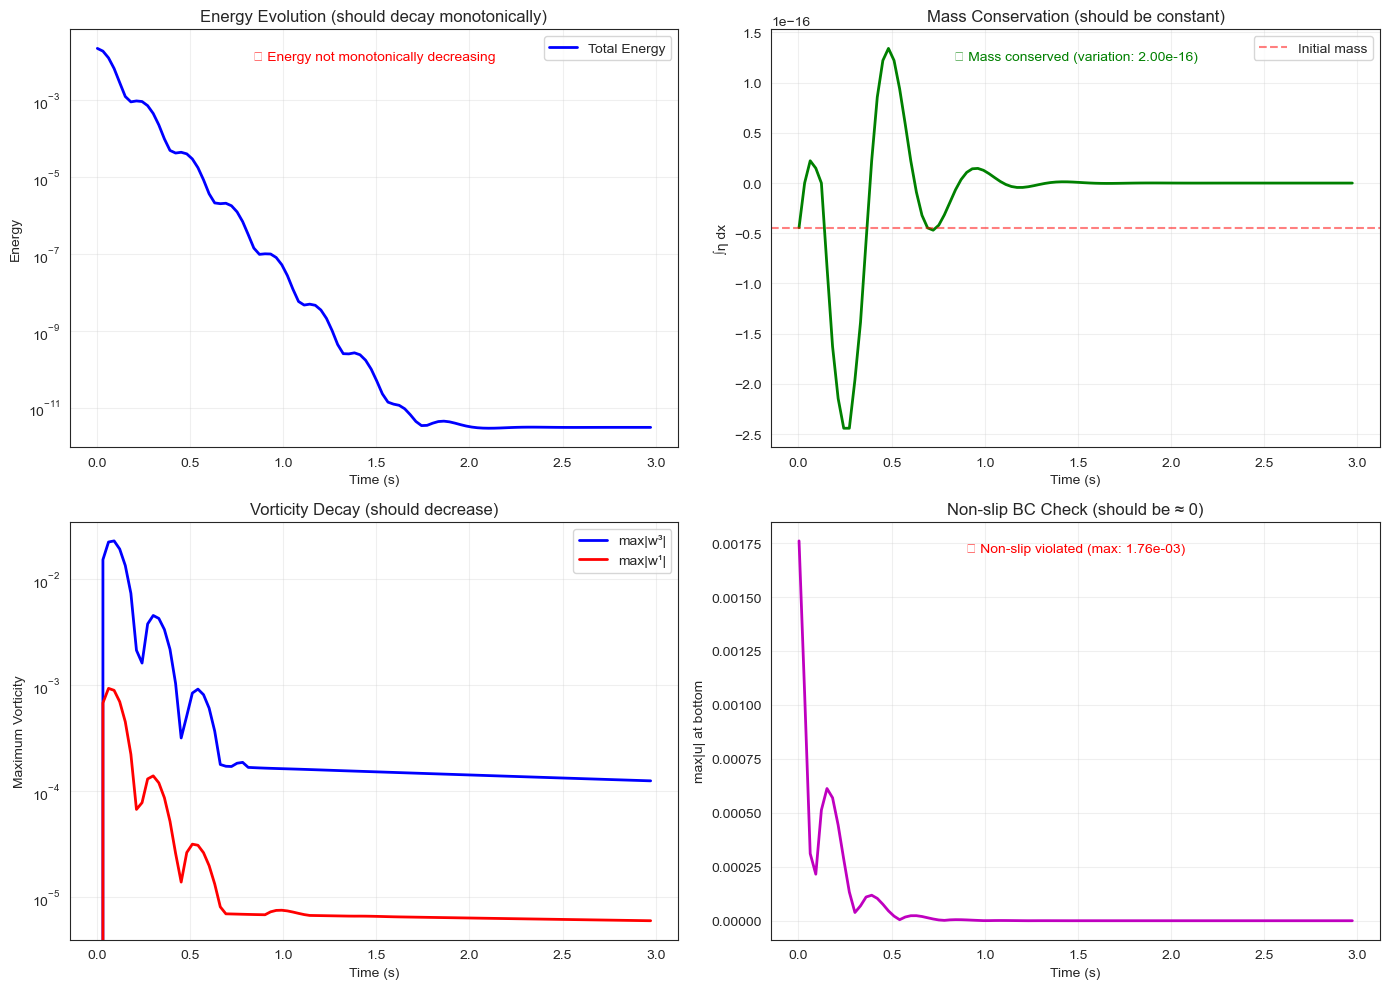


===== VERIFICATION SUMMARY =====
1. Energy decay: ⚠ Check needed
2. Mass conservation: variation = 2.00e-16
3. Max vorticity |w³|: initial=0.0000e+00, final=1.2491e-04
4. Max vorticity |w¹|: initial=0.0000e+00, final=6.0152e-06
5. Non-slip BC: max|u|_bottom = 1.76e-03


In [69]:
# ============== VERIFICATION PLOTS ==============
# These plots help verify that the simulation is physically correct

fig_verify, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Energy Decay (should be monotonically decreasing)
ax1 = axes[0, 0]
ax1.plot(time_points, energy_history, 'b-', linewidth=2, label='Total Energy')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Energy')
ax1.set_title('Energy Evolution (should decay monotonically)')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()
# Check if energy is decreasing
energy_diff = np.diff(energy_history)
if np.all(energy_diff <= 0):
    ax1.text(0.5, 0.95, '✓ Energy monotonically decreasing', 
             transform=ax1.transAxes, fontsize=10, color='green', 
             verticalalignment='top', horizontalalignment='center')
else:
    ax1.text(0.5, 0.95, '⚠ Energy not monotonically decreasing', 
             transform=ax1.transAxes, fontsize=10, color='red',
             verticalalignment='top', horizontalalignment='center')

# 2. Mass Conservation (∫η dx should be constant ≈ 0)
ax2 = axes[0, 1]
ax2.plot(time_points, mass_history, 'g-', linewidth=2)
ax2.axhline(y=mass_history[0], color='r', linestyle='--', alpha=0.5, label='Initial mass')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('∫η dx')
ax2.set_title('Mass Conservation (should be constant)')
ax2.grid(True, alpha=0.3)
ax2.legend()
# Check mass conservation
mass_variation = np.max(np.abs(np.array(mass_history) - mass_history[0]))
if mass_variation < 1e-6:
    ax2.text(0.5, 0.95, f'✓ Mass conserved (variation: {mass_variation:.2e})', 
             transform=ax2.transAxes, fontsize=10, color='green',
             verticalalignment='top', horizontalalignment='center')
else:
    ax2.text(0.5, 0.95, f'⚠ Mass variation: {mass_variation:.2e}', 
             transform=ax2.transAxes, fontsize=10, color='orange',
             verticalalignment='top', horizontalalignment='center')

# 3. Vorticity Decay (should decrease due to viscous diffusion)
ax3 = axes[1, 0]
ax3.plot(time_points, max_w3_history, 'b-', linewidth=2, label='max|w³|')
ax3.plot(time_points, max_w1_history, 'r-', linewidth=2, label='max|w¹|')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Maximum Vorticity')
ax3.set_title('Vorticity Decay (should decrease)')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Non-slip BC Check (|u| at bottom should be ≈ 0)
ax4 = axes[1, 1]
ax4.plot(time_points, bottom_velocity_history, 'm-', linewidth=2)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('max|u| at bottom')
ax4.set_title('Non-slip BC Check (should be ≈ 0)')
ax4.grid(True, alpha=0.3)
# Check non-slip condition
max_bottom_vel = np.max(bottom_velocity_history)
if max_bottom_vel < 1e-3:
    ax4.text(0.5, 0.95, f'✓ Non-slip satisfied (max: {max_bottom_vel:.2e})', 
             transform=ax4.transAxes, fontsize=10, color='green',
             verticalalignment='top', horizontalalignment='center')
else:
    ax4.text(0.5, 0.95, f'⚠ Non-slip violated (max: {max_bottom_vel:.2e})', 
             transform=ax4.transAxes, fontsize=10, color='red',
             verticalalignment='top', horizontalalignment='center')

plt.tight_layout()
plt.savefig('02_Surface_Dynamics_updated/Outputs/verification_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n===== VERIFICATION SUMMARY =====")
print(f"1. Energy decay: {'✓ OK' if np.all(np.diff(energy_history) <= 0) else '⚠ Check needed'}")
print(f"2. Mass conservation: variation = {mass_variation:.2e}")
print(f"3. Max vorticity |w³|: initial={max_w3_history[0]:.4e}, final={max_w3_history[-1]:.4e}")
print(f"4. Max vorticity |w¹|: initial={max_w1_history[0]:.4e}, final={max_w1_history[-1]:.4e}")
print(f"5. Non-slip BC: max|u|_bottom = {max_bottom_vel:.2e}")